<a href="https://colab.research.google.com/github/MedicalImageAnalysisTutorials/ImageRegistrationTutorial/blob/master/m2p_image_registration_example_mse_translation_RegularStepGradientDescent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Registration using Mean Squared Error Metric, 2D Translation Transform, and Regular Step Gradient Descent** 

This is a complete image registration example for beginners. It uses MSE metric, to find parameters of a 2D translation transform using gradient descent optimiser. I first provide an example using ITK tool then using a simple python implmentation.


References:
* [Insight Into Images book](https://dl.acm.org/doi/book/10.5555/1024225).
* [ITK Software Guide Book 2](https://itk.org/ITKSoftwareGuide/html/Book2/ITKSoftwareGuide-Book2ch3.html).
* A related [video lecture](http://biglab.ri.cmu.edu/galeotti/methods_course/video_of_lectures_2012/Class19-720p-1Mbps.mp4) by John Galeotti.


### TODOs:

* Implement interpolation
* Implement transformation

I believe learning is two-ways communications. If you have a question, correction, or feedback, you are more than welcome to open an issue and I will try to answer. 

For questions, I suggest ask in popular platform e.g. stack exchange or [ITK official forum](https://discourse.itk.org/) to get answers from more experts, you may link this notebook in your question. 


<br/> 
This tutorial is prepared by: [Ibraheem Al-Dhamari](mailto:ibr.exg@gmail.com). 

----



## Instalaltion

 

In [1]:

#========================================
#                  Setup
#========================================
!pip install itk
!pip install vtk
!pip install SimpleITK
!pip install Pillow
#clone data files from github
! rm -r PapersExplained
!git clone  https://github.com/MedicalImageAnalysisTutorials/PapersExplained.git

print("Python version : ")  

!python --version

# - compatibility with Python 2
from __future__ import print_function  # print('me') instead of print 'me'
from __future__ import division  # 1/2 = 0.5, not 0

# - import common modules
import os, time, random, IPython, datetime, math, itk, PIL, urllib.request

import numpy as np,  scipy.ndimage as snd, pandas as pd,SimpleITK as sitk
import plotly.offline as pyo,  plotly.graph_objs as go, cufflinks as cf
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.pyplot as plt

from sys import argv
from scipy import ndimage, misc, signal, stats
from PIL import Image, ImageDraw
from datetime import date
from plotly import __version__
from plotly.offline import iplot
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
from ipywidgets import *
from IPython.html.widgets import *
from numpy import array, linalg, matrix
# from scipy.misc import comb as nOk

 # the Python plotting package
#%matplotlib notebook
%matplotlib inline

# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

myDataPath       = "PapersExplained/Data"


     |████████████████████████████████| 14.4MB 10.4MB/s 
     |████████████████████████████████| 50.1MB 80kB/s 
     |████████████████████████████████| 36.3MB 119kB/s 
     |████████████████████████████████| 10.3MB 17.0MB/s 
     |████████████████████████████████| 68.0MB 58kB/s 
     |████████████████████████████████| 14.0MB 39.2MB/s 
     |████████████████████████████████| 103.4MB 39kB/s 
     |████████████████████████████████| 42.5MB 102kB/s 
rm: cannot remove 'PapersExplained': No such file or directory
Cloning into 'PapersExplained'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 84 (delta 28), reused 43 (delta 6), pack-reused 0
Unpacking objects: 100% (84/84), done.
Python version : 
Python 3.6.9


/usr/local/lib/python3.6/dist-packages/IPython/html.py:14: ShimWarning:

The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.



## Input images and parameters

An image from ITK examples is downloaded  then we create a moving image by shifting the fixed image in x and y directions

downloading data
(257, 221)
(257, 221)
fixed image size    :  itkSize2 ([221, 257])
fixed image spacing :  itkVectorD2 ([1, 1])
fixed image origin  :  itkPointD2 ([0, 0])
moving image size    :  itkSize2 ([221, 257])
moving image spacing :  itkVectorD2 ([1, 1])
moving image origin  :  itkPointD2 ([0, 0])


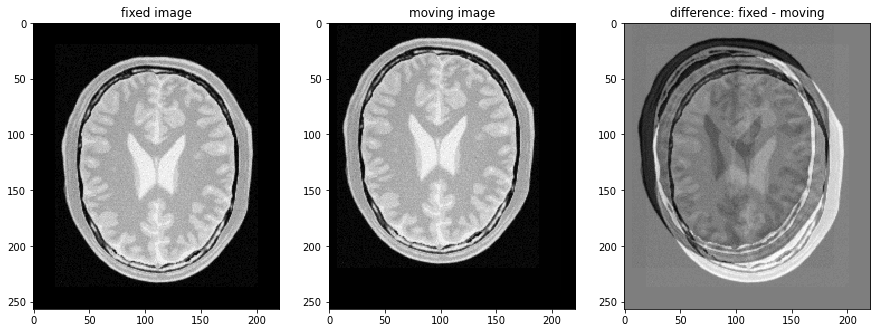

In [2]:
#---------------------------------------------------------------
# genral paramaeters:
#---------------------------------------------------------------

swImage       = 0 # switch moving and fixed

#Optimiser parameters
numIterations =  100  
stepSize      =  15
accuracy      =  0.00001 
# translation transform parameters 
tx  = 13; 
ty  = 17; 
mu  = [tx,ty]


#---------------------------------------------------------------
# Input data 
#---------------------------------------------------------------
print("downloading data")
fixedFilename  = "BrainProtonDensitySliceBorder20.png"
fixedLink = "https://github.com/InsightSoftwareConsortium/ITK/raw/master/Examples/Data/BrainProtonDensitySliceBorder20.png"
urllib.request.urlretrieve (fixedLink, fixedFilename)

def imTransform(imgA,tPars):
    #input image array and a transformation matrix, return transformed image array
    img = sitk.GetImageFromArray(imgA)
    origin = img.GetOrigin()
    img.SetOrigin((0,0,0))
    transform = sitk.TranslationTransform(2)
    transform.SetParameters(tPars)
    outimage=sitk.Resample(img,img.GetSize(),transform,sitk.sitkLinear,[0,0,0], img.GetSpacing(), img.GetDirection())
    outimage.SetOrigin(origin)
    resultImage = sitk.GetArrayFromImage(outimage)
    return resultImage

def getMovingImage(fixed,mu,isMSE):
    #transform     
    imgA =imTransform(itk.GetArrayFromImage(fixed),mu)
    if not isMSE:
       #invert in case of mutual information 
       imgA = np.max(imgA)-imgA 
    movingImage = itk.GetImageFromArray(imgA)
    movingImage.CopyInformation(fixed)
    return movingImage

#  Reading the image using ITK

# define data types
dimension         = 2
PixelType         = itk.F
FixedImageType    = itk.Image[PixelType, dimension]
MovingImageType   = itk.Image[PixelType, dimension]

fixedImageReader  = itk.ImageFileReader[FixedImageType].New()
fixedImageReader.SetFileName(fixedFilename);   fixedImageReader.Update()
fixedImage        = fixedImageReader.GetOutput()
# fixedImageRegion  = fixedImage.GetBufferedRegion()

# generate a moving image 
# to test the effect of multi-modality we can invert the color by replacing 1 with 0
movingImage = getMovingImage(fixedImage,mu,1)

u  = itk.GetArrayFromImage(fixedImage)   
v  = itk.GetArrayFromImage(movingImage) 
print(u.shape)
print(v.shape)
f,axs = plt.subplots(1, 3);
f.set_figheight(15);f.set_figwidth(15)
axs[0].set_title('fixed image')
axs[0].imshow(u)
axs[1].set_title('moving image')
axs[1].imshow(v)
axs[2].set_title('difference: fixed - moving')
axs[2].imshow(u-v)


print("fixed image size    : ", fixedImage.GetLargestPossibleRegion().GetSize())
print("fixed image spacing : ", fixedImage.GetSpacing())
print("fixed image origin  : ", fixedImage.GetOrigin())

print("moving image size    : ", movingImage.GetLargestPossibleRegion().GetSize())
print("moving image spacing : ", movingImage.GetSpacing())
print("moving image origin  : ", movingImage.GetOrigin())


## Image registration

Image registtraion is the problem of finding parameters $\mu$ of a transformation $T(P,\mu)$ that aligns an image called the moving image $I_M(P)$ to another imaeg called the fixed image $I_F(P)$.

Finding these parameters is challenging. Optimisation e.g. gradient descent optimiser is used to find these parameters. The gradient descent tries to minimise a similarity metric $S(I_F,I_M)$by updating a transformation parameters.

$$\tag{1}
\mu = \mathrm{arg\,min}\quad S(I_F(P),I_M(T(P,\mu_{init}))
$$

where $\mu_{init}$ is the initial parameters.

The Gradient Descent (GD) optimiser update the transformation parameters using: 
$$\tag{2}
 \mu = \mu - \lambda \frac{\partial S}{\partial \mu}
$$
where $]lambda$ is the step-size or the learning rate. To avoid making large jumps, one can use the Regular Step Gradient Descent RSGD:

$$\tag{3}
 \mu = \mu - d \frac{\partial S}{\partial \mu}
$$
where d is a decaying step-size that gets smaller when the gradient changes its direction e.g.:

$$
d = \lambda, \quad\quad  g*g \ge 0 \\
d = \lambda r, \quad\quad g*g \lt 0 
$$

where $r$ is a relaxing factor $0\lt r\lt 1$.

 check the implementation section to see how it works. 



 In this example the similarity metric is the mean squared error $S_{MSE}(I_F,I_M)$ which is defined as: 

$$\tag{4}
S_{MSE}(I_F(P),I_M(T(P,\mu)) =\frac{1}{n}\sum^{n-1}_{i=0}(I_F(p_i)-I_M(T(p_i,\mu)))^2
$$
where $n$ is the number of pixels in the image. 


The derivative of this metric is :

$$\tag{5}
   \frac{\partial S_{MSE}(I_F(P),I_M(T(P,\mu))}{\partial \mu}=\frac{2}{n}\sum^{n-1}_{i=0}[\left(I_M(T(p_i,\mu)- I_F(p_i))\right)\left(\frac{-\partial I_M(T(p,\mu))}{\partial \mu}\right)] 
$$

Using chain rule:

$$\tag{6}
   \frac{\partial S_{MSE}}{\partial \mu}=\frac{2}{n}\sum^{n-1}_{i=0}[\left( I_M(T(p_i,\mu)-I_F(p_i))\right)\frac{\partial I_M(T(\tilde p,\mu))}{\partial \tilde p}\frac{\partial (T(p_i,\mu))}{\partial \mu}]
$$

where:

* $\left( I_M(T(p_i,\mu)-I_F(p_i))\right)$ is constant during the optimisation
* $\frac{\partial I_M(T(\tilde p,\mu))}{\partial \tilde p}$ is also constant during the optimisation. We compute the gradient of the moving image $dI_M=\frac{\partial I_M(p)}{\partial p}$ (one time operation before the optimisation). During the optiisation we get a transform point $\tilde p_i=T(p_i,\mu))$, then we get the intensity value $v$ from the moving image gradient at a transformed point location $v=dI_M(\tilde p)$. 
* $\frac{\partial (T(p_i,\mu))}{\partial \mu}$ is a row from $J_\mu$ that represent the current point.  $J_\mu$ is the Jacobian of the transformation with repect to its parameters. Note that $J_\mu$ is computed during each iteration of the optimisation:

$$\tag{7}
J_\mu = \frac{\partial T(P,\mu)}{\partial \mu}=\begin{pmatrix}
\frac{\partial T(p_1,\mu_1)}{\partial \mu_{1}}& \frac{\partial T(p_1,\mu_2)}{\partial \mu_{2}}   & \frac{\partial T(p_1,\mu_3)}{\partial \mu_{3}}  & . & . & . &  \frac{\partial T(p_1,\mu_m)}{\partial \mu_{m}} \\
\frac{\partial T(p_2,\mu_1)}{\partial \mu_{1}}   & \frac{\partial T(p_2,\mu_2)}{\partial \mu_{2}}   & \frac{\partial T(p_2,\mu_3)}{\partial \mu_{3}}  & . & . & . &  \frac{\partial x_{2}}{\partial \mu_{m}} \\ 
&  &  .&  &  &  & \\ 
 &  &  .&  &  &  & \\ 
 &  &  .&  &  &  & \\ 
 \frac{\partial T(p_n,\mu_1)}{\partial \mu_{1}}   & \frac{\partial T(p_n,\mu_2)}{\partial \mu_{2}}   & \frac{\partial T(p_n,\mu_3)}{\partial \mu_{3}}  & . & . & . &  \frac{\partial T(p_n,\mu_m)}{\partial \mu_{m}} \\ 
\end{pmatrix}
$$

Note that $J_\mu=\frac{\partial T(P,\mu)}{\partial \mu}$ is differnt from the Jacobian of the transformation $J=\frac{\partial T(P,\mu)}{\partial P}$ 

**Math Explaination:**

$\frac{\partial T(p_i,\mu_j)}{\partial \mu_{1}}$ means the derivative of the transformation $T$ at point location $p$ with repect to the transform parameter $\mu_j$. Here is an example, assuming:

* a 2D point $p = (x,y)=(2,3)$
* a 2D translation transform $T(p,\mu) = T((x,y),(\mu_0,\mu_1)) = (x+\mu0,y+\mu_1)$
* we have :

$$
\frac{\partial T(p,\mu)}{\partial \mu}=\frac{\partial T((x,y),(\mu_0,\mu_1))}{\partial (\mu_0,\mu_1) }= \\
\begin{pmatrix}
  \frac{\partial (x+\mu0,y+\mu_1)}{\partial \mu_0}  \\ 
  \frac{\partial (x+\mu0,y+\mu_1)}{\partial \mu_1}  \\
\end{pmatrix}
\begin{pmatrix}
  \frac{\partial (x+\mu0)}{\partial \mu_0} & \frac{\partial (y+\mu_1)}{\partial \mu_0}\\ 
  \frac{\partial (x+\mu0)}{\partial \mu_1} & \frac{\partial (y+\mu_1)}{\partial \mu_1}\\ 
\end{pmatrix} = \begin{pmatrix}
  1 & 0  \\ 
  0 & 1  \\ 
\end{pmatrix}
$$

In this example we have :
$$
\frac{\partial T((2,3),\mu_0)}{\partial \mu_{0}}=(1,0) \\
\frac{\partial T((2,3),\mu_1)}{\partial \mu_{1}}=(0,1)
$$

which means the term:

$$
   \underbrace{(I_F(p_i)-I_M(T(p_i,\mu)))}_\text{scalar} \underbrace{\frac{\partial I_M(T(\tilde p,\mu))}{\partial \tilde p}}_\text{[dx,dy]}\underbrace{\frac{\partial (T(p_i,\mu))}{\partial \mu}}_\text{[[1,0],[0,1]]}=[d\mu0,d\mu_1] = [scalar * (dx *1 +dy*0) , scalar * (dx *0 +dy*1)  ] =[scalar*dx,scalar*dy]
$$

So it seems to update the parameters we just multiply the gradient of the transformed point with twice the error value then divided by the number of pixels. 



## ITK example 

Here I am using an ITK example to align the input fixed and moving images.   

In [12]:
# This is an image registration code using ITK
InternalImageType = itk.Image[itk.F, dimension]

FixedNormalizeFilterType = itk.NormalizeImageFilter[FixedImageType, InternalImageType]
MovingNormalizeFilterType = itk.NormalizeImageFilter[MovingImageType, InternalImageType]
GaussianFilterType = itk.DiscreteGaussianImageFilter[InternalImageType, InternalImageType]

OptimizerType        = itk.RegularStepGradientDescentOptimizerv4

RegistrationType     = itk.ImageRegistrationMethodv4[InternalImageType, InternalImageType]  
InterpolatorType     = itk.LinearInterpolateImageFunction[InternalImageType, itk.D]
TransformType        = itk.TranslationTransform[itk.D, dimension]

miMetricType     = itk.MutualInformationImageToImageMetric[InternalImageType, InternalImageType]
mseMetricType    = itk.MeanSquaresImageToImageMetric[InternalImageType, InternalImageType]


#Instantiate the classes 
fixedSmoother = GaussianFilterType.New()
movingSmoother = GaussianFilterType.New()
fixedNormalizer = FixedNormalizeFilterType.New()
movingNormalizer = MovingNormalizeFilterType.New()

transform    = TransformType.New()
optimizer    = OptimizerType.New()
interpolator = InterpolatorType.New()
registration = RegistrationType.New()
metricMI       = miMetricType.New()
metricMSE      = mseMetricType.New()

fixedSmoother = GaussianFilterType.New()
movingSmoother = GaussianFilterType.New()

#preprocessing
# normalization is important  
fixedNormalizer.SetInput(fixedImage)
movingNormalizer.SetInput(movingImage)
fixedNormalizer.Update()

metric =  metricMSE
metric.SetUseAllPixels(True)

initialParameters = transform.GetParameters()
initialParameters[0] = 0.0 # Initial offset in mm along X
initialParameters[1] = 0.0 # Initial offset in mm along Y

# it seems smoothing is not important for mutual information
fixedSmoother.SetVariance(2.0)
movingSmoother.SetVariance(2.0)
fixedSmoother.SetInput(fixedNormalizer.GetOutput())
movingSmoother.SetInput(movingNormalizer.GetOutput())

# fixedImage  = fixedNormalizer.GetOutput()
# movingImage = movingNormalizer.GetOutput()

fixedImage  = fixedSmoother.GetOutput()
movingImage = movingSmoother.GetOutput()

u = itk.GetArrayFromImage(fixedImage)
v = itk.GetArrayFromImage(movingImage)

#image registration 
registration.SetOptimizer(optimizer)
#registration.SetTransform(transform)
#registration.SetInterpolator(interpolator)
registration.SetMetric(metric)
registration.SetFixedImage(fixedImage)
registration.SetMovingImage(movingImage)

# registration.SetFixedImage(fixedImage)
# registration.SetMovingImage(movingImage)

registration.SetInitialTransformParameters(initialParameters)


optimizer.SetLearningRate(stepSize)
optimizer.SetRelaxationFactor(0.5)
optimizer.SetNumberOfIterations(numIterations)
optimizer.SetMinimize(True) 

# Create the Command observer and register it with the optimizer.
def iterationUpdate():
    currentParameter = registration.GetOutput().Get().GetParameters()
    print( "%d : M: %f   P: %f %f " % (optimizer.GetCurrentIteration(), optimizer.GetValue(),  currentParameter.GetElement(0), currentParameter.GetElement(1)))
    if optimizer.GetValue()<accuracy:
       optimizer.StopOptimization()
observer = itk.PyCommand.New()
observer.SetCommandCallable(iterationUpdate)
optimizer.AddObserver(itk.IterationEvent(), observer)


registration.Update()
   

finalParameters = registration.GetLastTransformParameters()
TranslationAlongX = finalParameters[0]
TranslationAlongY = finalParameters[1]
numberOfIterations = optimizer.GetCurrentIteration()
bestValue = optimizer.GetValue()


# Print out results
print("Result = ")
print(" Translation X = " + str(TranslationAlongX))
print(" Translation Y = " + str(TranslationAlongY))
print(" Iterations    = " + str(numberOfIterations))
print(" Metric value  = " + str(bestValue))

ResampleFilterType = itk.ResampleImageFilter[MovingImageType, FixedImageType]

finalTransform = TransformType.New()
finalTransform.SetParameters(finalParameters)
finalTransform.SetFixedParameters(transform.GetFixedParameters())

resample = ResampleFilterType.New()
resample.SetTransform(finalTransform)
resample.SetInput(movingImage)
resample.SetDefaultPixelValue(100)
resample.SetSize(fixedImage.GetLargestPossibleRegion().GetSize())
resample.SetOutputOrigin(fixedImage.GetOrigin())
resample.SetOutputSpacing(fixedImage.GetSpacing())
resample.SetOutputDirection(fixedImage.GetDirection())

registeredImage = resample.GetOutput()
r0 = itk.GetArrayFromImage(registeredImage)


# visualize the result 
print(u.shape)
print(v.shape)
f,axs = plt.subplots(1, 4);
f.set_figheight(15);f.set_figwidth(15)
axs[0].set_title('fixed image')
axs[0].imshow(u)
axs[1].set_title('moving image')
axs[1].imshow(v)
axs[2].set_title('difference before: fixed - moving')
axs[2].imshow(u-v)
axs[3].set_title('difference after: fixed - registered')
axs[3].imshow(u-r0)

print("all tasks are done!.............")

TypeError: ignored

## Simple Implementation

numIterations :  100
stepSize      :  50
0 :  0.3485487170867299  ,  [-6.574411792050816, -6.515204099145584]
1 :  0.21846189884588973  ,  [-9.509035101742061, -10.654683357760184]
2 :  0.1585053939358593  ,  [-11.399395369745385, -14.182739545115727]
3 :  0.12369876489955456  ,  [-11.684601823569212, -15.475497468798586]
4 :  0.1234034680941555  ,  [-11.680518942131858, -15.518056322258175]
5 :  0.12712246781850273  ,  [-11.691763519691328, -15.526829850043436]
6 :  0.1270365928355591  ,  [-11.688070703957585, -15.527066205510105]
7 :  0.12705252299307182  ,  [-11.68944268871062, -15.526856048196763]
8 :  0.12704708112059176  ,  [-11.688926726827441, -15.526939352187341]
9 :  0.12704910140500378  ,  [-11.689120971644014, -15.526907839133166]
10 :  0.12704834487296865  ,  [-11.689047846176363, -15.526919755238648]
11 :  0.12704861997552688  ,  [-11.689075338600277, -15.526915265829533]
12 :  0.12704851681206755  ,  [-11.689065076972891, -15.526916960716806]
13 :  0.1270485511998873  , 

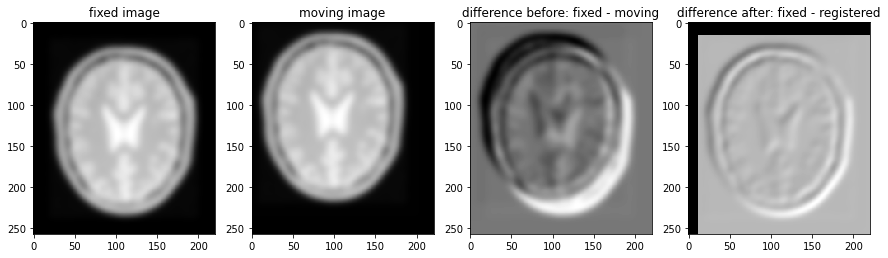

In [19]:
# Note, we will use the same preprocessed input images as in ITK
# TODO: use our implemnetation of:
# image gradient
# image interpolation

def mbNormalize(x):
   # normalize: nx will have a mean = 0 and std = 1
    nx = ( x - np.mean(x) ) /  np.std(x)
    return nx 

#mse metric
def mseMetric(u,v):
    mbMSE  = 0.0
    n = 1
    for i in range(len(u.shape)): 
        n =  n * u.shape[i]  
    mbMSE  = np.sum([pow(x-y,2) for x,y in zip(u,v) ]) / float(n)
    #mbSMSE = math.sqrt(mbMSE)
    return mbMSE

def mbConvolution(F,g):
    #Todo: add implementation
    #convolution of  function F with a filter g
    cF = 0
    return cF
def mbImageGradient(F):
    # retrun:
    # image gradient for each dimension: [dF/dx,dF/dy,...]
    # image magnitude dFmag= math.sqrt(dx^2+dy^2)
    # image direction: theta = math.atan(dy/dx)

    # using Sobel kernel
    SbX2D = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    SbY2D = np.array([[1,2,1 ],[0,0,0 ],[-1,-2,-1]])
    dX = ndimage.convolve(F, SbX2D, mode='constant', cval=0.0)
    dY = ndimage.convolve(F, SbY2D, mode='constant', cval=0.0)
    g = np.dstack((dX,dY))
    return g
# get image gradient using ITK
def imGradient(img):
    f = itk.GetImageFromArray(img)
    df = itk.gradient_image_filter(f)
    g = itk.GetArrayFromImage(df)        
    return g

#mse derivative  
def mbdMSE(u,v,dT):
    # dMSE the derivative of mse with repect to the transform parameters mu
    # dM   =  d M(y)/ dy    # gradient of the transformed moving image
    # dT   =  D T(x,mu) / dmu # gradient of the transformation with respect to its parameters mu 
    # dMdT = d M(y)/ dy * D T(x,mu) / dmu

    dMSE  = 0.0
    # compute the gradient of the transformed image
    #dM = imGradient(v)
    dM = mbImageGradient(v)

    # the first term in eq.4, a scalar
    n = 1
    for i in range(len(u.shape)): 
        n =  n * u.shape[i]  
    dmse = (2/float(n))* (v-u)

    # second and third terms in eq.4 
    dMdT = np.array([0.0,0.0])
    for i in range(dM.shape[0]):
        for j in range(dM.shape[1]):
            dx = dM[i,j,0]
            dy = dM[i,j,1]
            dxy0 = np.dot([dx,dy],dT[:,0]) 
            dxy1 = np.dot([dx,dy],dT[:,1])             
            dMdT[0] = dMdT[0] + dmse[i,j]*dxy0 
            dMdT[1] = dMdT[1] + dmse[i,j]*dxy1
            # we can also use the gradient directly as dT is just identity matrix
            # dMdT[0] = dMdT[0] + dmse[i,j]*dx
            # dMdT[1] = dMdT[1] + dmse[i,j]*dy

    dMSE = np.array([dMdT[0], dMdT[1]])
    return     dMSE  # this should be a vector of length d dimension


# image registration using regular step gradient descent
def rsgdOptimiser(u,v,numIterations,stepSize,relaxingFactor):
    # initial parameters 
    nMu       = [0,0]
    dMu0       = [1,1]

    stepSizes = np.array([ stepSize for j in range (2)])
    dT = np.array([[1,0],[0,1]])
    # start the optimisation
    for i in range(numIterations):
        # transform the moving image using nMu
        v_t = imTransform(v,nMu)
        tMshow = 0
        if tMshow:
            f = plt.figure();f.set_figheight(15);f.set_figwidth(15)
            f.add_subplot(1,2, 1)
            plt.imshow(v_t)
        #compute the metric value
        mv = mseMetric(u,v_t)
        # compute the metric derivative
        dMu = mbdMSE(u,v_t,dT)
        
        # update the parameters 
        for j in range(2):
            #check the gradient direction         
            if  dMu0[j] * dMu[j] < 0.0 :            
                stepSizes[j] = stepSizes[j] *relaxingFactor
            nMu[j] = nMu[j] - stepSizes[j]   * dMu[j]
        dMu0 = dMu    
        print(i,": ",mv," , ", nMu)
    return nMu

print("numIterations : ", numIterations)
print("stepSize      : ", stepSize)   

# numIterations = 119
stepSize        = 50
relaxingFactor  = 1

fMu =  rsgdOptimiser(u,v,numIterations,stepSize,relaxingFactor )

r0=imTransform(v,fMu)
f,axs = plt.subplots(1, 4);
f.set_figheight(15);f.set_figwidth(15)
axs[0].set_title('fixed image')
axs[0].imshow(u)
axs[1].set_title('moving image')
axs[1].imshow(v)
axs[2].set_title('difference before: fixed - moving')
axs[2].imshow(u-v)
axs[3].set_title('difference after: fixed - registered')
axs[3].imshow(u-r0)
